In [2]:
import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
returns = pd.read_csv("../data/100portfolioReturns.csv")
returns = returns.rename(columns={"Unnamed: 0": "Date"})
returns = returns[["Date", "65"]] # Using the dataset with the smallest beta that outperformed the market
returns

,Date,65
0,2012-04-02 00:00:00,0.000000
1,2012-04-03 00:00:00,-0.004758
2,2012-04-04 00:00:00,-0.014394
3,2012-04-05 00:00:00,-0.015044
4,2012-04-09 00:00:00,-0.027466
...,...,...
2511,2022-03-24 00:00:00,2.831964
2512,2022-03-25 00:00:00,2.838108
2513,2022-03-28 00:00:00,2.868783
2514,2022-03-29 00:00:00,2.947379


In [4]:
betas = pd.read_csv("../data/100portfolioBetas_v2.csv")
betas = betas.rename(columns={"Unnamed: 0": "Date"})
betas = betas[["Date", "65"]] # Using the dataset with the smallest beta that outperformed the market
betas

,Date,65
0,2012-04-03,1.192912
1,2012-04-04,1.003700
2,2012-04-05,0.999831
3,2012-04-09,1.040367
4,2012-04-10,1.001715
...,...,...
2510,2022-03-24,1.205783
2511,2022-03-25,1.206229
2512,2022-03-28,1.206683
2513,2022-03-29,1.207197


In [3]:
def splitting_tr_te(df, size=0.7):
    
    split_point = int(df.shape[0]*size)

    train = df.iloc[:split_point]
    test = df.iloc[split_point:]
    return train, test

In [4]:
def make_es(data):
    es = ft.EntitySet("Returns")

    es.add_dataframe(
        data,
        dataframe_name="returns",
        index="id",
        make_index=True,
        time_index="Date",
    )
    return es

In [38]:
from featuretools.primitives import NumericLag
from featuretools.primitives import RollingMean
from featuretools.primitives import RollingMax
from featuretools.primitives import RollingMin
from featuretools.primitives import RollingSTD

gap = 126
window_length = 21

dt_primitives = ["Day", "Month", "Year", "Weekday"]

delaying_primitives = [NumericLag(periods=i + gap) for i in range(window_length)]

rolling_mean_primitive = RollingMean(window_length=window_length,
                                     gap=gap,
                                     min_periods=window_length)

rolling_min_primitive = RollingMin(window_length=window_length,
                                     gap=gap,
                                     min_periods=window_length)

rolling_max_primitive = RollingMax(window_length=window_length,
                                     gap=gap,
                                     min_periods=window_length)

rolling_std_primitive = RollingSTD(window_length=window_length,
                                     gap=gap,
                                     min_periods=window_length)

es = make_es(returns)

/opt/anaconda3/envs/model/lib/python3.9/site-packages/featuretools/entityset/entityset.py:747: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index, make_index
  warnings.warn(


In [39]:
fm, f = ft.dfs(entityset=es,
               target_dataframe_name='returns',
               trans_primitives = (dt_primitives +
                                   delaying_primitives +
                                  [rolling_mean_primitive, rolling_min_primitive, rolling_max_primitive, rolling_std_primitive])
              )

f

/opt/anaconda3/envs/model/lib/python3.9/site-packages/featuretools/synthesis/deep_feature_synthesis.py:161: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn(


[<Feature: 65>,
 <Feature: DAY(Date)>,
 <Feature: MONTH(Date)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=126)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=127)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=128)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=129)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=130)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=131)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=132)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=133)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=134)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=135)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=136)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=137)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=138)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=139)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=140)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=141)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=142)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=143)>,
 <Feature: NUMERIC_LAG(Date, 65, periods=144)>,
 <Feature: NUMERIC_LAG(D

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

lr = LinearRegression()

test = fm.dropna()

X = test.iloc[:, 1:]
y = test.iloc[:, 0]

X_train, X_test = splitting_tr_te(X)
y_train, y_test = splitting_tr_te(y)

lr.fit(X_train, y_train)


LinearRegression()

In [41]:
y_preds = lr.predict(X_test)
model_preds = lr.predict(X_train)

print(f"Training MSE: \t{mean_squared_error(y_train, model_preds)}")
print(f"Training R2: \t{r2_score(y_train, model_preds)}")
print(f"Test MSE: \t{mean_squared_error(y_test, y_preds)}")
print(f"Test R2: \t{r2_score(y_test, y_preds)}")

Training MSE: 	0.006323402585516119
Training R2: 	0.9286547116828746
Test MSE: 	0.45676671198847074
Test R2: 	0.11468587835235533


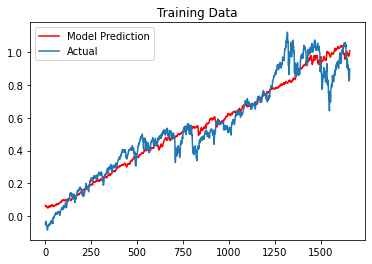

In [42]:
plt.plot(model_preds, c="r", label="Model Prediction")
plt.plot(y_train.reset_index(drop=True), label="Actual")
plt.title("Training Data")
plt.legend()
plt.show()

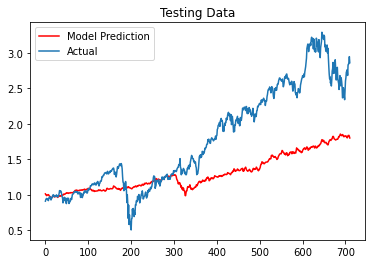

In [43]:
plt.plot(y_preds, c="r", label="Model Prediction")
plt.plot(y_test.reset_index(drop=True), label="Actual")
plt.title("Testing Data")
plt.legend()
plt.show()

In [44]:
fm.head()

,65,DAY(Date),MONTH(Date),"NUMERIC_LAG(Date, 65, periods=126)","NUMERIC_LAG(Date, 65, periods=127)","NUMERIC_LAG(Date, 65, periods=128)","NUMERIC_LAG(Date, 65, periods=129)","NUMERIC_LAG(Date, 65, periods=130)","NUMERIC_LAG(Date, 65, periods=131)","NUMERIC_LAG(Date, 65, periods=132)",...,"NUMERIC_LAG(Date, 65, periods=143)","NUMERIC_LAG(Date, 65, periods=144)","NUMERIC_LAG(Date, 65, periods=145)","NUMERIC_LAG(Date, 65, periods=146)","ROLLING_MAX(Date, 65, window_length=21, gap=126, min_periods=21)","ROLLING_MEAN(Date, 65, window_length=21, gap=126, min_periods=21)","ROLLING_MIN(Date, 65, window_length=21, gap=126, min_periods=21)","ROLLING_STD(Date, 65, window_length=21, gap=126, min_periods=21)",WEEKDAY(Date),YEAR(Date)
id,,,,,,,,,,,,,,,,,,,,,
0,0.000000,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2012
1,-0.004758,3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2012
2,-0.014394,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2012
3,-0.015044,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2012
4,-0.027466,9,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2012


In [45]:
fm.to_csv(f"../data/portfolio{fm.columns[0]}_{gap/21}month_prediction.csv")